In [1]:

# Car Price Prediction - Advanced Model Training & Hyperparameter Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
# --- 1. Load and Explore Dataset ---

df = pd.read_csv("CarPrice_Assignment.csv")

print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Display datatypes and categorical columns
print("\nData types:\n", df.dtypes)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", cat_cols)



Dataset Shape: (205, 26)
   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horse

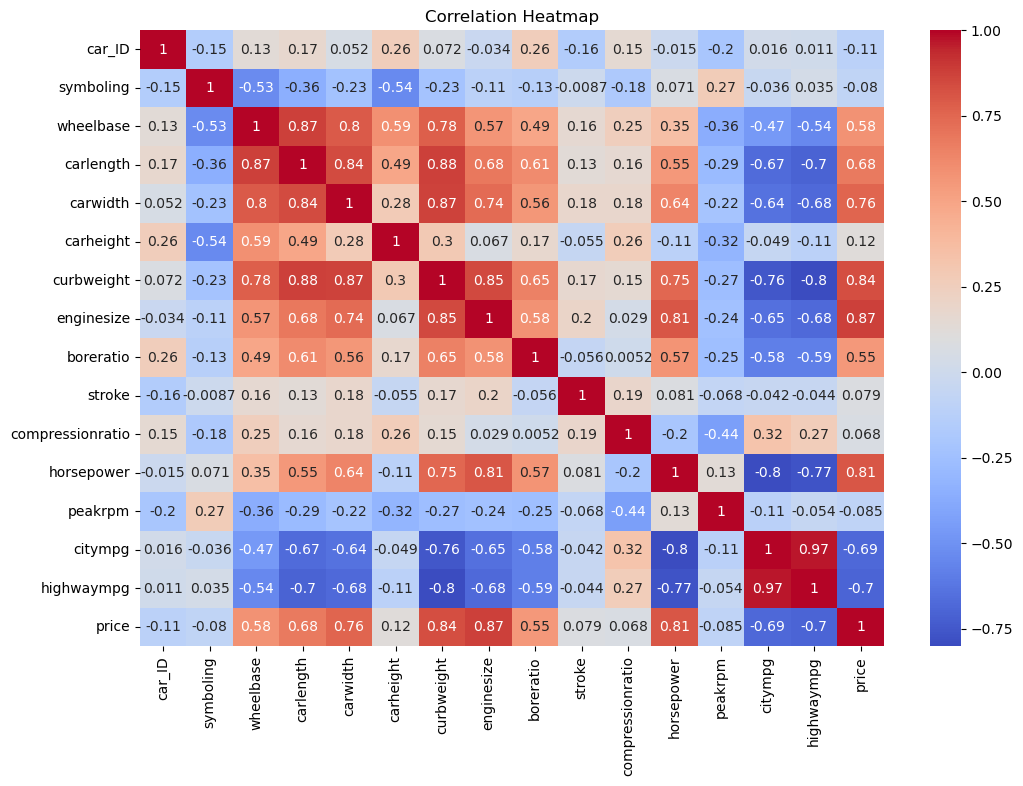

In [3]:
# --- 2. Visualization: Correlation Heatmap ---

plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [4]:
# --- 3. Preprocessing ---

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Save feature columns & categorical info for later use
cat_levels = {col: df[col].unique().tolist() for col in cat_cols}


print(f"\nTotal features after encoding: {X_encoded.shape[1]}")



Total features after encoding: 190


In [5]:
# --- 4. Split into train and test sets ---

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


In [6]:
# --- 5. Scale Features ---

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# --- 6. Define utility to print model performance ---

def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} performance:")
    print(f" R2 Score: {r2:.4f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" MAE: {mae:.2f}")
    print("-"*30)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}


In [8]:
# --- 7. Hyperparameter Tuning ---

results = {}

# 7.1 SVR with GridSearchCV
print("Tuning SVR...")
svr = SVR()
svr_params = {
    'kernel': ['rbf', 'linear'],
    'C': [1, 10, 50, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}

svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train)

print("Best SVR params:", svr_grid.best_params_)
print(f"Best CV R2: {svr_grid.best_score_:.4f}")

svr_best = svr_grid.best_estimator_
y_pred_svr = svr_best.predict(X_test_scaled)
results['SVR'] = evaluate_model("SVR", y_test, y_pred_svr)


Tuning SVR...
Best SVR params: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV R2: 0.7775
SVR performance:
 R2 Score: 0.7801
 RMSE: 4166.12
 MAE: 2590.29
------------------------------


In [9]:
# 7.2 KNN Regressor with GridSearchCV
print("Tuning KNN...")
knn = KNeighborsRegressor()
knn_params = {'n_neighbors': list(range(3, 11))}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='r2', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

print("Best KNN params:", knn_grid.best_params_)
print(f"Best CV R2: {knn_grid.best_score_:.4f}")

knn_best = knn_grid.best_estimator_
y_pred_knn = knn_best.predict(X_test_scaled)
results['KNN'] = evaluate_model("KNN", y_test, y_pred_knn)

Tuning KNN...
Best KNN params: {'n_neighbors': 5}
Best CV R2: 0.3839
KNN performance:
 R2 Score: 0.2896
 RMSE: 7488.73
 MAE: 3981.95
------------------------------


In [10]:

# 7.3 Polynomial Regression with degree 2 (no hyperparameter tuning here)
print("Training Polynomial Regression degree=2...")
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
results['Polynomial Regression'] = evaluate_model("Polynomial Regression", y_test, y_pred_poly)


Training Polynomial Regression degree=2...
Polynomial Regression performance:
 R2 Score: -0.0337
 RMSE: 9033.54
 MAE: 5521.99
------------------------------


In [11]:
# 7.4 Lasso Regression Grid Search
print("Tuning Lasso Regression...")
lasso = Lasso(max_iter=1000000)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)

print("Best Lasso params:", lasso_grid.best_params_)
print(f"Best CV R2: {lasso_grid.best_score_:.4f}")

lasso_best = lasso_grid.best_estimator_
y_pred_lasso = lasso_best.predict(X_test_scaled)
results['Lasso'] = evaluate_model("Lasso", y_test, y_pred_lasso)


Tuning Lasso Regression...
Best Lasso params: {'alpha': 100}
Best CV R2: 0.7739
Lasso performance:
 R2 Score: 0.7953
 RMSE: 4020.17
 MAE: 2565.42
------------------------------


In [12]:
# 7.5 Ridge Regression Grid Search
print("Tuning Ridge Regression...")
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)

print("Best Ridge params:", ridge_grid.best_params_)
print(f"Best CV R2: {ridge_grid.best_score_:.4f}")

ridge_best = ridge_grid.best_estimator_
y_pred_ridge = ridge_best.predict(X_test_scaled)
results['Ridge'] = evaluate_model("Ridge", y_test, y_pred_ridge)


Tuning Ridge Regression...
Best Ridge params: {'alpha': 10}
Best CV R2: 0.7912
Ridge performance:
 R2 Score: 0.7919
 RMSE: 4053.01
 MAE: 2519.07
------------------------------


In [13]:
# 7.6 ElasticNet Regression Grid Search
print("Tuning ElasticNet Regression...")
elastic = ElasticNet(max_iter=8000)
elastic_params = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_grid = GridSearchCV(elastic, elastic_params, cv=5, scoring='r2', n_jobs=-1)
elastic_grid.fit(X_train_scaled, y_train)

print("Best ElasticNet params:", elastic_grid.best_params_)
print(f"Best CV R2: {elastic_grid.best_score_:.4f}")

elastic_best = elastic_grid.best_estimator_
y_pred_elastic = elastic_best.predict(X_test_scaled)
results['ElasticNet'] = evaluate_model("ElasticNet", y_test, y_pred_elastic)


Tuning ElasticNet Regression...
Best ElasticNet params: {'alpha': 1, 'l1_ratio': 0.9}
Best CV R2: 0.7926
ElasticNet performance:
 R2 Score: 0.7944
 RMSE: 4029.21
 MAE: 2521.47
------------------------------



Summary of Model Performance:
                             R2         RMSE          MAE
Lasso                  0.795275  4020.171805  2565.415048
ElasticNet             0.794354  4029.210416  2521.471948
Ridge                  0.791917  4053.008642  2519.071983
SVR                    0.780141  4166.116712  2590.294773
KNN                    0.289609  7488.734440  3981.952854
Polynomial Regression -0.033706  9033.544747  5521.989448


/var/folders/r_/8tp1l67x6rq0nls3q2vyj4_w0000gn/T/ipykernel_19424/3660004474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='R2', data=results_df, palette='viridis')


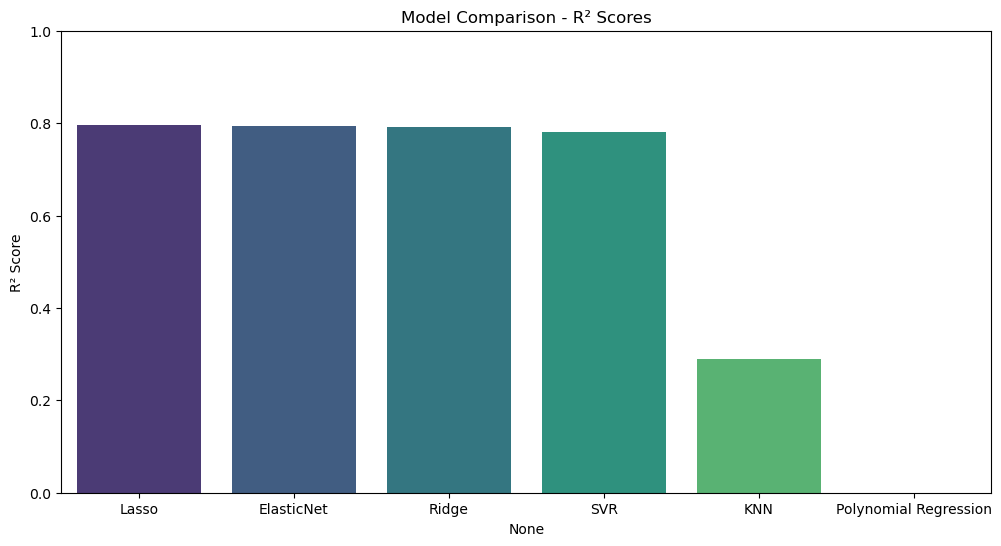

In [14]:
# --- 8. Summarize results ---

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print("\nSummary of Model Performance:")
print(results_df)

# Plot R2 scores for visual comparison
plt.figure(figsize=(12,6))
sns.barplot(x=results_df.index, y='R2', data=results_df, palette='viridis')
plt.title("Model Comparison - R² Scores")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.show()

In [26]:
# --- 9. Save models, scaler, and metadata for Streamlit app ---

print("Saving models, scaler, and metadata...")

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(svr_best, 'svr_model.joblib')
joblib.dump(knn_best, 'knn_model.joblib')
joblib.dump(poly_model, 'poly_model.joblib')
joblib.dump(poly_features, 'poly_features.joblib')  # Needed to transform in streamlit
joblib.dump(lasso_best, 'lasso_model.joblib')
joblib.dump(ridge_best, 'ridge_model.joblib')
joblib.dump(elastic_best, 'elastic_model.joblib')

metadata = {
    'feature_columns': X_encoded.columns.tolist(),
    'categorical_columns': cat_cols,
    'category_levels': cat_levels,
    'original_columns': X.columns.tolist()
}
joblib.dump(metadata, 'metadata.joblib')

print("All saved successfully!")

Saving models, scaler, and metadata...
All saved successfully!
